# **Challenge Explanation**

This document presents your coding challenge as part of your application for ***Builtrix*** Open Position.

The following list are the electrical appliances from REFIT open dataset. It is a 2-bedroom apartment built between 1900 - 1910 and has three occupants. The dataset is stored in csv format in two different files (RAW_House_P1 & RAW_House_P2). It is in time series format and beside the time columns, it has 9 columns that are respectively:

0.Aggregate, 1.Fridge, 2.Freezer, 3.Fridge-Freezer, 4.Washing Machine 1, 5.Washing Machine 2, 6.Desktop Computer, 7.Television, 8.Microwave, 9.Kettle,

with power consumptions in ***Watt***.

The dataset is timestamped and sampled at 8 second intervals (not always!) and it is ***not clean***. So, the cleaning is performed for:

1- merging the two files (also timestamp duplicates is merged). <br>
2- Individual Appliance readings is set to 0 Watts if above 4000 Watts (above the rated limit of the sensor). <br>
3- NaN values are filled with proper methods (< 2-minute gaps) or zeroed or removed (> 2-minute gaps). <br>
4- Other cleanings when necessary.<br>

The goal is to disaggregate the aggregated power (column C) into the major appliances (D to L) in the house. Thus, we need you to identify the operational status of the appliances only by the aggregated signal (and other features you identify in date and time) and then estimate the consumption of appliances.

## Import necessary libraries and packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer, LSTM, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU,PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## Read both .CSV files and merge them

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
house_part1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Builtrix data/RAW_House_P1.csv', encoding = 'UTF-8', header = 0)
house_part2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Builtrix data/RAW_House_P2.csv', encoding = 'UTF-8', header = 0)
df = pd.merge(house_part1, house_part2, how='outer')
df['timestamp'] = df['Unix'].astype("datetime64[s]")
df = df.set_index(df['timestamp'].values)
df.drop(['Unix','timestamp', 'Time'], axis=1, inplace=True)

## Clean the data

In [ ]:
df.shape

(8455486, 10)

In [ ]:
df.describe()

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
count,8.244512e+06,8.062020e+06,8.063054e+06,8.054454e+06,8.079342e+06,8.048886e+06,8.245914e+06,8.158148e+06,8.086510e+06,8.150872e+06
mean,3.806739e+02,1.068457e+01,6.403073e+01,3.848839e+01,4.412760e+00,1.160047e+01,1.443560e+01,2.389956e+01,9.582997e+00,1.095508e+01
std,4.287898e+02,1.777035e+02,2.559318e+02,1.974058e+02,1.186911e+02,2.518413e+02,5.630290e+01,7.992700e+01,1.399579e+02,1.687727e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.940000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00
50%,2.970000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00
75%,4.710000e+02,0.000000e+00,1.340000e+02,1.230000e+02,0.000000e+00,0.000000e+00,1.100000e+01,6.400000e+01,2.000000e+00,0.000000e+00
max,6.566300e+04,9.830100e+04,9.830100e+04,9.830100e+04,6.758100e+04,9.284000e+04,6.554100e+04,6.559700e+04,6.578900e+04,9.830100e+04


filling Nan values with zeros (<2minutes_gaps) as the sampling rate is 8 s, let's take a limit of 10 and then we will drop the other nan


In [ ]:
df=df.fillna(method='ffill',  limit=10)
df = df.dropna()
df.shape

(8354649, 10)

Resampling the data to 15 minutes

In [ ]:
df=df.resample("15Min").mean()
df = df.dropna()
df

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
2013-10-11 11:15:00,587.979167,52.083333,146.911458,0.000000,3.723958,0.0,102.619792,0.000000,2.0,0.0
2013-10-11 11:30:00,722.694631,40.520134,131.674497,99.157718,3.741611,0.0,102.805369,0.000000,2.0,0.0
2013-10-11 11:45:00,252.633333,0.000000,8.446667,0.000000,3.780000,0.0,102.386667,0.000000,2.0,0.0
2013-10-11 12:00:00,284.304636,0.000000,0.000000,0.000000,3.635762,0.0,102.033113,0.000000,2.0,0.0
2013-10-11 12:15:00,337.500000,0.000000,6.406667,84.920000,3.760000,0.0,102.630000,0.000000,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2015-07-07 08:45:00,493.874016,0.000000,131.881890,39.779528,0.000000,0.0,0.000000,29.251969,2.0,0.0
2015-07-07 09:00:00,374.174603,9.500000,129.031746,51.857143,0.000000,0.0,0.000000,29.007937,2.0,0.0
2015-07-07 09:15:00,362.488189,51.519685,121.976378,0.102362,0.000000,0.0,0.000000,14.196850,2.0,0.0
2015-07-07 09:30:00,216.906977,7.201550,0.000000,86.891473,0.000000,0.0,0.000000,0.000000,2.0,0.0


## Exploratory Data Analysis (EDA)

In [ ]:
dates = {}
for i in range(1,2):
    dates[i] = [str(time)[:10] for time in df.index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House data contain 594 days from 2013-10-11 to 2015-07-07.
['2013-10-11', '2013-10-12', '2013-10-13', '2013-10-14', '2013-10-15', '2013-10-16', '2013-10-17', '2013-10-18', '2013-10-19', '2013-10-20', '2013-10-21', '2013-10-22', '2013-10-23', '2013-10-24', '2013-10-25', '2013-10-26', '2013-10-27', '2013-10-28', '2013-10-29', '2013-10-30', '2013-10-31', '2013-11-01', '2013-11-02', '2013-11-03', '2013-11-04', '2013-11-05', '2013-11-06', '2013-11-07', '2013-11-08', '2013-11-09', '2013-11-10', '2013-11-11', '2013-11-12', '2013-11-13', '2013-11-14', '2013-11-15', '2013-11-16', '2013-11-17', '2013-11-18', '2013-11-19', '2013-11-20', '2013-11-21', '2013-11-22', '2013-11-23', '2013-11-24', '2013-11-25', '2013-11-26', '2013-11-27', '2013-11-28', '2013-11-29', '2013-11-30', '2013-12-01', '2013-12-02', '2013-12-03', '2013-12-04', '2013-12-05', '2013-12-06', '2013-12-07', '2013-12-08', '2013-12-09', '2013-12-10', '2013-12-11', '2013-12-12', '2013-12-13', '2013-12-14', '2013-12-15', '2013-12-16', '2

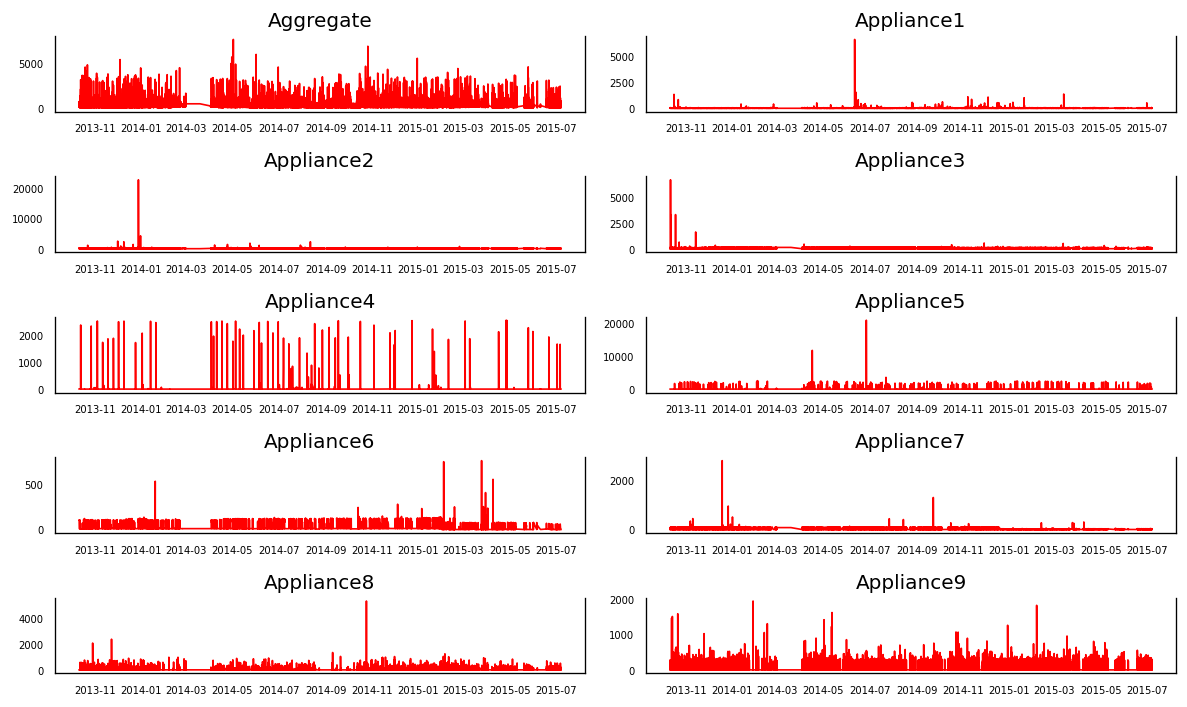

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

We will focus on three appliances ( Appliance3:Fridge-Freezer, Appliance 4:Washing Machine_1 and appliance 8:Microwave). We will drop the rest

In [ ]:
df.drop(['Appliance1','Appliance2','Appliance5','Appliance6','Appliance7','Appliance9'], axis=1, inplace=True)
df

,Aggregate,Appliance3,Appliance4,Appliance8
2013-10-11 11:15:00,587.979167,0.000000,3.723958,2.0
2013-10-11 11:30:00,722.694631,99.157718,3.741611,2.0
2013-10-11 11:45:00,252.633333,0.000000,3.780000,2.0
2013-10-11 12:00:00,284.304636,0.000000,3.635762,2.0
2013-10-11 12:15:00,337.500000,84.920000,3.760000,2.0
...,...,...,...,...
2015-07-07 08:45:00,493.874016,39.779528,0.000000,2.0
2015-07-07 09:00:00,374.174603,51.857143,0.000000,2.0
2015-07-07 09:15:00,362.488189,0.102362,0.000000,2.0
2015-07-07 09:30:00,216.906977,86.891473,0.000000,2.0


In [ ]:
df.rename(columns = {'Appliance3':'fridge_freezer', 'Appliance4':'washing_machine_1', 'Appliance8':'microwave'}, inplace = True)
df

,Aggregate,fridge_freezer,washing_machine_1,microwave
2013-10-11 11:15:00,587.979167,0.000000,3.723958,2.0
2013-10-11 11:30:00,722.694631,99.157718,3.741611,2.0
2013-10-11 11:45:00,252.633333,0.000000,3.780000,2.0
2013-10-11 12:00:00,284.304636,0.000000,3.635762,2.0
2013-10-11 12:15:00,337.500000,84.920000,3.760000,2.0
...,...,...,...,...
2015-07-07 08:45:00,493.874016,39.779528,0.000000,2.0
2015-07-07 09:00:00,374.174603,51.857143,0.000000,2.0
2015-07-07 09:15:00,362.488189,0.102362,0.000000,2.0
2015-07-07 09:30:00,216.906977,86.891473,0.000000,2.0


 Setting Individual Appliance readings to 0 Watts if above 4000 Watts

In [ ]:
df['fridge_freezer'][df['fridge_freezer'] > 4000] = 0
df['washing_machine_1'][df['washing_machine_1'] > 4000] = 0
df['microwave'][df['microwave'] > 4000] = 0


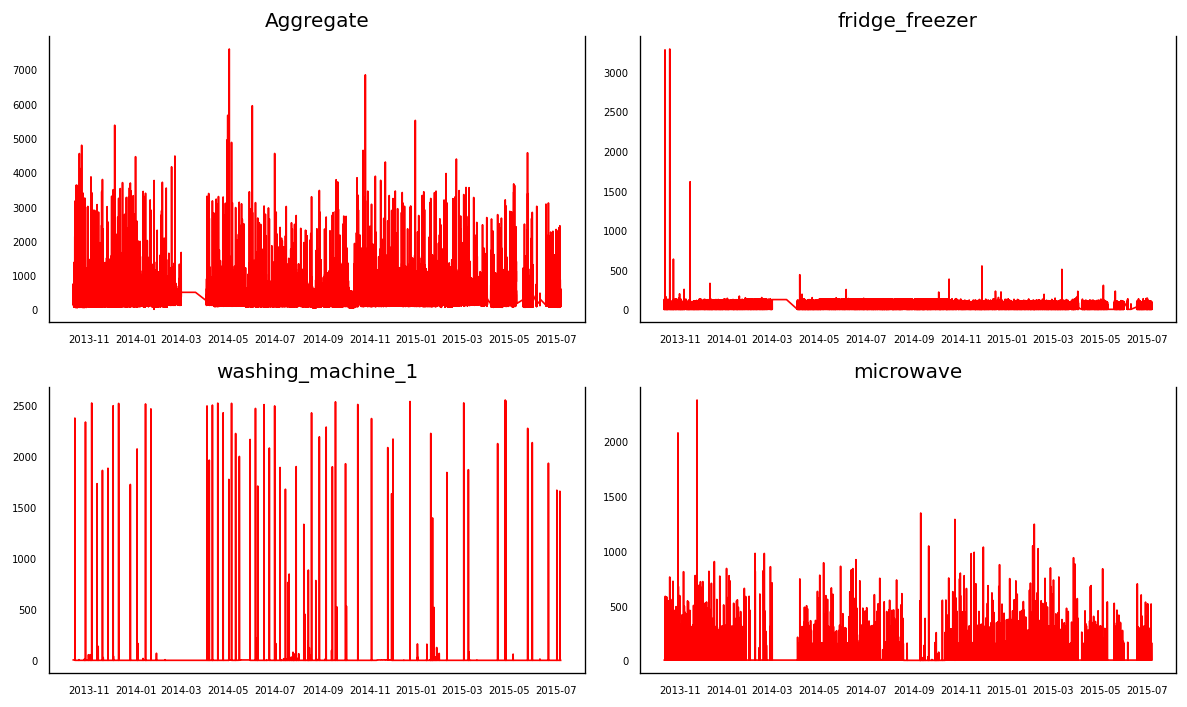

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Feature Engineering

Assuming appliances are ON when their power consumption exceeds 50 watts

In [ ]:
df.loc[df['fridge_freezer'] > 50, 'label_fridge_freezer'] = 1
df.loc[df['fridge_freezer'] < 50, 'label_fridge_freezer'] = 0

df.loc[df['washing_machine_1'] > 50, 'label_washing_machine_1'] = 1
df.loc[df['washing_machine_1'] < 50, 'label_washing_machine_1'] = 0

df.loc[df['microwave'] > 50, 'label_microwave'] = 1
df.loc[df['microwave'] < 50, 'label_microwave'] = 0

df


,Aggregate,fridge_freezer,washing_machine_1,microwave,label_fridge_freezer,label_washing_machine_1,label_microwave
2013-10-11 11:15:00,587.979167,0.000000,3.723958,2.0,0.0,0.0,0.0
2013-10-11 11:30:00,722.694631,99.157718,3.741611,2.0,1.0,0.0,0.0
2013-10-11 11:45:00,252.633333,0.000000,3.780000,2.0,0.0,0.0,0.0
2013-10-11 12:00:00,284.304636,0.000000,3.635762,2.0,0.0,0.0,0.0
2013-10-11 12:15:00,337.500000,84.920000,3.760000,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
2015-07-07 08:45:00,493.874016,39.779528,0.000000,2.0,0.0,0.0,0.0
2015-07-07 09:00:00,374.174603,51.857143,0.000000,2.0,1.0,0.0,0.0
2015-07-07 09:15:00,362.488189,0.102362,0.000000,2.0,0.0,0.0,0.0
2015-07-07 09:30:00,216.906977,86.891473,0.000000,2.0,1.0,0.0,0.0


In [ ]:
df = df.dropna()

Separate data into train (80%--475 days) and  test data (20%--118 days)

In [ ]:
df1_train = df.loc[:dates[1][475]]
df1_test = df.loc[dates[1][476]:]
print('df_train.shape: ', df1_train.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (42858, 7)
df_test.shape:  (10504, 7)


We will use a sliding window

In [ ]:
def window(yourArray, winSize):
    sliding_windows = []                                    
    for i in range(0, yourArray.shape[0]-winSize+1):
        window = yourArray[i:i+winSize,:].reshape((-1,1)) # each individual window
        sliding_windows.append(window)
    result = np.hstack(sliding_windows)
    return result

In [ ]:
X_train = df1_train[['Aggregate']].values
X_test = df1_test[['Aggregate']].values

#fridge_freezer target for ON/OFF classification and power estimation
y_fridge_classification_train = df1_train['label_fridge_freezer'].values
y_fridge_classification_test = df1_test['label_fridge_freezer'].values

y_fridge_estimation_train = df1_train['fridge_freezer'].values
y_fridge_estimation_test = df1_test['fridge_freezer'].values


# washing machine target for ON/OFF classification and power estimation
y_wm_classification_train = df1_train['label_washing_machine_1'].values
y_wm_classification_test = df1_test['label_washing_machine_1'].values

y_wm_estimation_train = df1_train['washing_machine_1'].values
y_wm_estimation_test = df1_test['washing_machine_1'].values

#Microwave target for ON/OFF classification and power estimation
y_microwave_classification_train = df1_train['label_microwave'].values
y_microwave_classification_test = df1_test['label_microwave'].values

y_microwave_estimation_train = df1_train['microwave'].values
y_microwave_estimation_test = df1_test['microwave'].values

## Modelling

Model 1 fridge status classification. Let's use SVM classification model

In [ ]:
Xtrain1= (window(X_train, 10)).transpose()
Xtest1= (window(X_test, 10)).transpose()
y_fridge_classification_train = y_fridge_classification_train[0:Xtrain1.shape[0]]
y_fridge_classification_test = y_fridge_classification_test[0:Xtest1.shape[0]]
print(Xtrain1.shape, y_fridge_classification_train.shape, Xtest1.shape, y_fridge_classification_test.shape)

(42849, 10) (42849,) (10495, 10) (10495,)


In [ ]:
model1 = svm.SVC()

In [ ]:
model1.fit(Xtrain1, y_fridge_classification_train)

SVC()

In [ ]:
y_fridge_classif_predict = model1.predict(Xtest1).reshape(-1)

Model 2 fridge power estimation

sliding window size = 10

In [ ]:
Xtrain= (window(X_train, 10)).transpose()
Xtest= (window(X_test, 10)).transpose()

In [ ]:
X_train2 = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
X_test2 = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))
y_fridge_estimation_train = y_fridge_estimation_train[0:X_train2.shape[0]]
y_fridge_estimation_test = y_fridge_estimation_test[0:X_test2.shape[0]]
print(X_train2.shape, y_fridge_estimation_train.shape, X_test2.shape, y_fridge_estimation_test.shape)

(42849, 1, 10) (42849,) (10495, 1, 10) (10495,)


Let's use  bidirectional LSTM for power estimation

In [ ]:
def build_lstm_model(layers):
    model2 = Sequential()
    for i in range(len(layers) - 2):
        model2.add(Bidirectional(LSTM(layers[i+1],
            input_dim=layers[i],
            activation="relu",
            return_sequences= True if i < len(layers) - 3 else False )))
        model2.add(Dropout(0.3))
        
    model2.add(Dense(1024,activation="relu"))
    model2.add(Dense(layers[-1]))
    model2.build(input_shape=[None, 1, 10])
    model2.summary()
    return model2

model2 = build_lstm_model([10,64,128,1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 128)           38400     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1024)              263168    
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [ ]:
start = time.time()
adam = Adam(lr = 5e-5)
model2.compile(loss='mse', optimizer=adam,  metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="./bilstmfridge_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model2.fit(
            X_train2,
            y_fridge_estimation_train,
            batch_size=512,
            verbose=1,
            epochs=100,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


59/59 [==============================] - 6s 28ms/step - loss: 3422.2852 - accuracy: 0.0087 - val_loss: 1600.2214 - val_accuracy: 3.1116e-04
Epoch 2/100
59/59 [==============================] - 1s 16ms/step - loss: 3047.4797 - accuracy: 8.3350e-04 - val_loss: 1622.9283 - val_accuracy: 3.8895e-04
Epoch 3/100
59/59 [==============================] - 1s 16ms/step - loss: 2938.1199 - accuracy: 0.0025 - val_loss: 1653.9177 - val_accuracy: 0.0012
Epoch 4/100
59/59 [==============================] - 1s 17ms/step - loss: 2893.6653 - accuracy: 0.0034 - val_loss: 1650.8080 - val_accuracy: 0.0019
Epoch 5/100
59/59 [==============================] - 1s 17ms/step - loss: 2858.8123 - accuracy: 0.0037 - val_loss: 1621.9087 - val_accuracy: 0.0016
Epoch 6/100
59/59 [==============================] - 1s 16ms/step - loss: 2840.2371 - accuracy: 0.0034 - val_loss: 1602.4523 - val_accuracy: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 19ms/step - loss: 2810.7883 - accuracy: 0.0031 - val_los

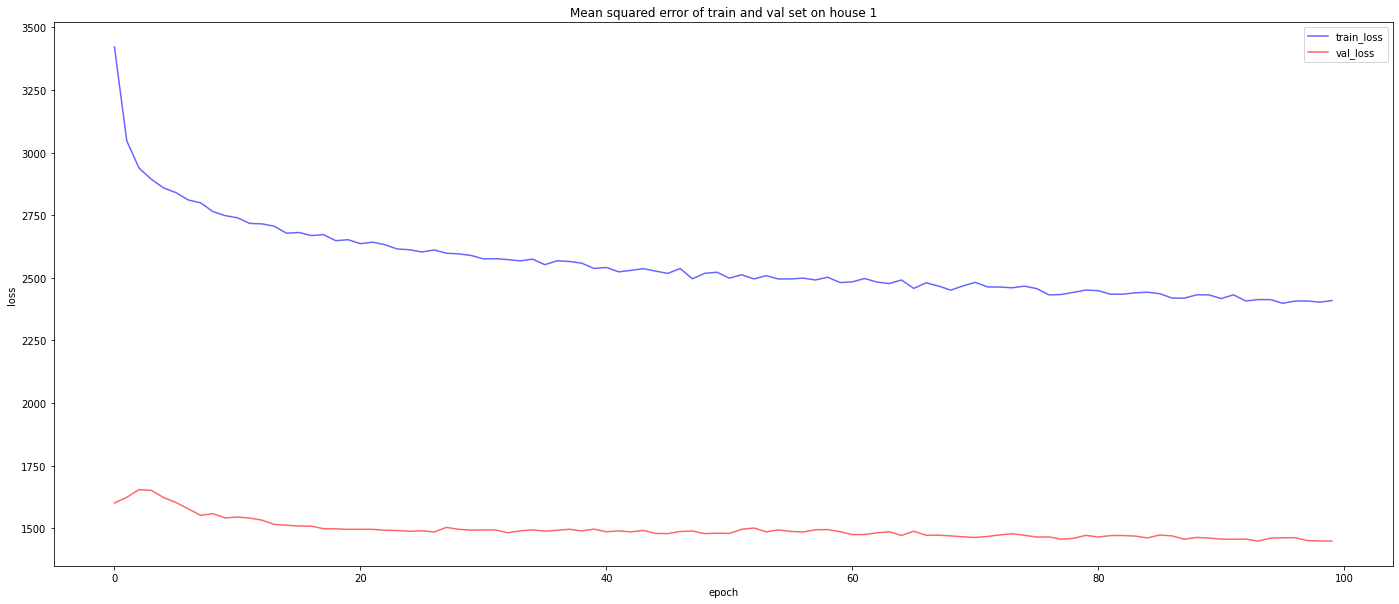

In [ ]:
train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [ ]:
#prediction
pred_lstm = model2.predict(X_test2).reshape(-1)
print(pred_lstm.shape)

(10495,)


Model 3  washing machine ON/OFF identification using SVM classification model

In [ ]:
y_wm_classification_train = y_wm_classification_train[0:Xtrain1.shape[0]]
y_wm_classification_test = y_wm_classification_test[0:Xtest1.shape[0]]
print(Xtrain1.shape, y_wm_classification_train.shape, Xtest1.shape, y_wm_classification_test.shape)

(42849, 10) (42849,) (10495, 10) (10495,)


In [ ]:
model3 = svm.SVC()
model3.fit(Xtrain1, y_wm_classification_train)
y_wm_classif_predict = model3.predict(Xtest1).reshape(-1)

Model 4  washing machine power estimation using biLSTM 

In [ ]:
y_wm_estimation_train = y_wm_estimation_train[0:X_train2.shape[0]]
y_wm_estimation_test = y_wm_estimation_test[0:X_test2.shape[0]]
print(X_train2.shape, y_wm_estimation_train.shape, X_test2.shape, y_wm_estimation_test.shape)

(42849, 1, 10) (42849,) (10495, 1, 10) (10495,)


In [ ]:
def build_lstm_model(layers):
    model4 = Sequential()
    for i in range(len(layers) - 2):
        model4.add(Bidirectional(LSTM(layers[i+1],
            input_dim=layers[i],
            activation="relu",
            return_sequences= True if i < len(layers) - 3 else False )))
        model4.add(Dropout(0.3))
        
    model4.add(Dense(1024,activation="relu"))
    model4.add(Dense(layers[-1]))
    model4.build(input_shape=[None, 1, 10])
    model4.summary()
    return model4

model4 = build_lstm_model([10,64,128,1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 1, 128)           38400     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              263168    
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
start = time.time()
adam = Adam(lr = 5e-5)
model4.compile(loss='mse', optimizer=adam,  metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="./bilstmwm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model4.fit(
            X_train2,
            y_wm_estimation_train,
            batch_size=512,
            verbose=1,
            epochs=100,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
59/59 [==============================] - 5s 27ms/step - loss: 7648.8481 - accuracy: 0.3688 - val_loss: 4183.7104 - val_accuracy: 0.3395
Epoch 2/100
59/59 [==============================] - 1s 19ms/step - loss: 7517.5239 - accuracy: 0.2571 - val_loss: 4135.2324 - val_accuracy: 0.3743
Epoch 3/100
59/59 [==============================] - 1s 18ms/step - loss: 7400.0845 - accuracy: 0.2894 - val_loss: 4091.5464 - val_accuracy: 0.3634
Epoch 4/100
59/59 [==============================] - 1s 19ms/step - loss: 7329.6128 - accuracy: 0.2406 - val_loss: 4045.5593 - val_accuracy: 0.4439
Epoch 5/100
59/59 [==============================] - 1s 19ms/step - loss: 7259.5435 - accuracy: 0.2891 - val_loss: 4004.4153 - val_accuracy: 0.4722
Epoch 6/100
59/59 [==============================] - 1s 19ms/step - loss: 7066.7510 - accuracy: 0.3070 - val_loss: 3968.5361 - val_accuracy: 0.4823
Epoch 7/100
59/59 [==============================] - 1s 18ms/step - loss: 6993.7544 - accuracy: 0.3084 - val_los

In [ ]:
#prediction
pred_lstm_wm = model4.predict(X_test2).reshape(-1)
print(pred_lstm_wm.shape)

(10495,)


Model 5 Microwave ON/OFF detection using SVM classification model

In [ ]:
y_microwave_classification_train = y_microwave_classification_train[0:Xtrain1.shape[0]]
y_microwave_classification_test = y_microwave_classification_test[0:Xtest1.shape[0]]
print(Xtrain1.shape, y_microwave_classification_train.shape, Xtest1.shape, y_microwave_classification_test.shape)

(42849, 10) (42849,) (10495, 10) (10495,)


In [ ]:
model5 = svm.SVC()
model5.fit(Xtrain1, y_microwave_classification_train)
y_microwave_classif_predict = model5.predict(Xtest1).reshape(-1)

Model 6 Microwave power estimation using BiLSTM

In [ ]:
y_microwave_estimation_train = y_microwave_estimation_train[0:X_train2.shape[0]]
y_microwave_estimation_test = y_microwave_estimation_test[0:X_test2.shape[0]]
print(X_train2.shape, y_microwave_estimation_train.shape, X_test2.shape, y_microwave_estimation_test.shape)

(42849, 1, 10) (42849,) (10495, 1, 10) (10495,)


In [ ]:
def build_lstm_model(layers):
    model6 = Sequential()
    for i in range(len(layers) - 2):
        model6.add(Bidirectional(LSTM(layers[i+1],
            input_dim=layers[i],
            activation="relu",
            return_sequences= True if i < len(layers) - 3 else False )))
        model6.add(Dropout(0.3))
        
    model6.add(Dense(1024,activation="relu"))
    model6.add(Dense(layers[-1]))
    model6.build(input_shape=[None, 1, 10])
    model6.summary()
    return model6

model6 = build_lstm_model([10,64,128,1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 1, 128)           38400     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
start = time.time()
adam = Adam(lr = 5e-5)
model4.compile(loss='mse', optimizer=adam,  metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="./bilstmmicrowave_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model4.fit(
            X_train2,
            y_microwave_estimation_train,
            batch_size=512,
            verbose=1,
            epochs=100,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


59/59 [==============================] - 6s 28ms/step - loss: 4421.1250 - accuracy: 0.0193 - val_loss: 3745.1553 - val_accuracy: 0.0048
Epoch 2/100
59/59 [==============================] - 1s 19ms/step - loss: 3843.7971 - accuracy: 0.0110 - val_loss: 3529.1440 - val_accuracy: 0.0037
Epoch 3/100
59/59 [==============================] - 1s 18ms/step - loss: 3393.5859 - accuracy: 0.0094 - val_loss: 3452.9189 - val_accuracy: 0.0023
Epoch 4/100
59/59 [==============================] - 1s 18ms/step - loss: 3243.7151 - accuracy: 0.0079 - val_loss: 3407.9600 - val_accuracy: 0.0018
Epoch 5/100
59/59 [==============================] - 1s 18ms/step - loss: 3209.5498 - accuracy: 0.0085 - val_loss: 3372.2939 - val_accuracy: 0.0018
Epoch 6/100
59/59 [==============================] - 1s 18ms/step - loss: 3060.0139 - accuracy: 0.0065 - val_loss: 3355.3542 - val_accuracy: 0.0038
Epoch 7/100
59/59 [==============================] - 1s 16ms/step - loss: 3065.4717 - accuracy: 0.0065 - val_loss: 3350.0764

In [ ]:
#prediction
pred_lstm_microwave = model6.predict(X_test2).reshape(-1)
print(pred_lstm_microwave.shape)

(10495,)


## Conclusion

Model 1 ON/OFF classification fridge results

In [ ]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True  positive= ', cm[1][1])
    print('False positive = ', cm[0][1])
    print('True negative = ', cm[0][0])
    print('False negative = ', cm[1][0])

In [ ]:
print_confusion_matrix(y_fridge_classification_test, y_fridge_classif_predict)
print("precison = ",precision_score(y_fridge_classification_test, y_fridge_classif_predict))
print("recall = ",recall_score(y_fridge_classification_test, y_fridge_classif_predict))
print("f1  = ",f1_score(y_fridge_classification_test, y_fridge_classif_predict))
print("accuracy  = ",accuracy_score(y_fridge_classification_test, y_fridge_classif_predict))

True  positive=  1344
False positive =  734
True negative =  6293
False negative =  2124
precison =  0.6467757459095284
recall =  0.3875432525951557
f1  =  0.48467363865849256
accuracy  =  0.7276798475464507


Model 2 Fridge power estimation results

In [ ]:
#Mean square error and Mean absolute error
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))

In [ ]:
mse_loss_lstm = mse_loss(pred_lstm, y_fridge_estimation_test)
mae_loss_lstm = mae_loss(pred_lstm, y_fridge_estimation_test)
EA = 1 - ((sum(abs(pred_lstm - y_fridge_estimation_test))))/(2*sum(y_fridge_estimation_test))
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)
print('Estimation accuracy :', EA)

Mean square error on test set:  1387.9451617473835
Mean absolute error on the test set:  29.180195558480165
Estimation accuracy : 0.5508915530315718


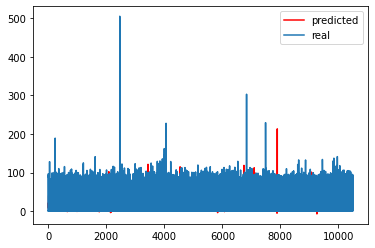

In [ ]:
%matplotlib inline
#%matplotlib notebook
plt.plot(pred_lstm, label='predicted',color='red')
plt.plot(y_fridge_estimation_test, label='real')
plt.legend()

Model 3 Washing machine ON/OFF classification results

In [ ]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True  positive= ', cm[1][1])
    print('False positive = ', cm[0][1])
    print('True negative = ', cm[0][0])
    print('False negative = ', cm[1][0])

print_confusion_matrix(y_wm_classification_test, y_wm_classif_predict)
print("precison = ",precision_score(y_wm_classification_test, y_wm_classif_predict))
print("recall = ",recall_score(y_wm_classification_test, y_wm_classif_predict))
print("f1  = ",f1_score(y_wm_classification_test, y_wm_classif_predict))
print("accuracy  = ",accuracy_score(y_wm_classification_test, y_wm_classif_predict))

True  positive=  4
False positive =  3
True negative =  10444
False negative =  44
precison =  0.5714285714285714
recall =  0.08333333333333333
f1  =  0.14545454545454545
accuracy  =  0.9955216769890424


Model 4 washing machine power estimation results

In [ ]:
#Mean square error and Mean absolute error
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))

mse_loss_lstm = mse_loss(pred_lstm_wm, y_wm_estimation_test)
mae_loss_lstm = mae_loss(pred_lstm_wm, y_wm_estimation_test)
EA = 1 - ((sum(abs(pred_lstm_wm - y_wm_estimation_test))))/(2*sum(y_wm_estimation_test))
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)
print('Estimation accuracy :', EA)

Mean square error on test set:  5342.779500302194
Mean absolute error on the test set:  6.223156808537916
Estimation accuracy : 0.12503155873483585


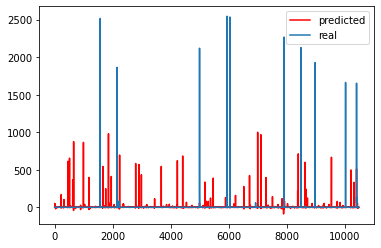

In [ ]:
%matplotlib inline
#%matplotlib notebook
plt.plot(pred_lstm_wm, label='predicted',color='red')
plt.plot(y_wm_estimation_test, label='real')
plt.legend()

Model 5 Microwave ON/OFF classification results

In [ ]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True  positive= ', cm[1][1])
    print('False positive = ', cm[0][1])
    print('True negative = ', cm[0][0])
    print('False negative = ', cm[1][0])

print_confusion_matrix(y_microwave_classification_test, y_microwave_classif_predict)
print("precison = ",precision_score(y_microwave_classification_test, y_microwave_classif_predict))
print("recall = ",recall_score(y_microwave_classification_test, y_microwave_classif_predict))
print("f1  = ",f1_score(y_microwave_classification_test, y_microwave_classif_predict))
print("accuracy  = ",accuracy_score(y_microwave_classification_test, y_microwave_classif_predict))

True  positive=  0
False positive =  0
True negative =  10088
False negative =  407
precison =  0.0
recall =  0.0
f1  =  0.0
accuracy  =  0.9612196283944736


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 6 microwave power estimation results

In [ ]:
#Mean square error and Mean absolute error
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))

mse_loss_lstm = mse_loss(pred_lstm_microwave, y_microwave_estimation_test)
mae_loss_lstm = mae_loss(pred_lstm_microwave, y_microwave_estimation_test)
EA = 1 - ((sum(abs(pred_lstm_microwave - y_microwave_estimation_test))))/(2*sum(y_microwave_estimation_test))
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)
print('Estimation accuracy :', EA)

Mean square error on test set:  2793.6704079846104
Mean absolute error on the test set:  12.213312000533946
Estimation accuracy : 0.4273730051372907


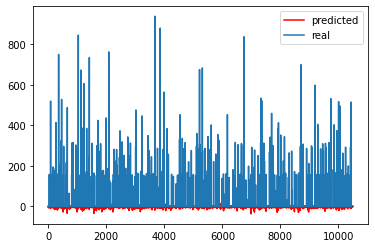

In [ ]:
%matplotlib inline
#matplotlib notebook
plt.plot(pred_lstm_microwave, label='predicted',color='red')
plt.plot(y_microwave_estimation_test, label='real')
plt.legend()

In conclusion, the models should be adjusted for better accuracy and other models could be tested. Moreover, the performance of the models could be improved by using for example a sampling rate of 1 minute instead of 15 minutes (used here because of time concerns).